## import & install & class

In [ ]:
pip install glove_python

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
from glove import Corpus, Glove
from sklearn.preprocessing import StandardScaler
#shap
# import shap
#ensemble
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, cross_val_predict
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats.mstats import gmean
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from gensim.models import word2vec


ModuleNotFoundError: No module named 'glove'

In [0]:
def oversample(x, n, seed=0):
  if n == 0:
      return list(x)
  uw = np.unique(x)
  bs = np.array([])
  np.random.seed(seed)
  for j in range(n):
      # bs = np.append(bs, x)
      bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
  return list(bs)

# def MAD(data):
#     return np.median(np.absolute(data - np.median(data, axis=0)), axis=0)

############################################################################################################################
class RandomSearchW2V(object):
  def __init__(self, param_grid, n_iter, X):
    self.param_grid = param_grid
    self.n_iter = n_iter
    
    #merge용 id
    ids = pd.DataFrame(X.cust_id.sort_values().unique(), columns=['cust_id'])
    #환불금액 제외
    X_real = X.query('amount > 0')
    #구매카테고리 lst
    items_lst = list(X_real.groupby('cust_id')[p_level].agg(oversample, 4)) # sampling
    #구매목록
    items= pd.DataFrame({'cust_id' : X_real.cust_id.unique(),  
                              'cats' : items_lst})
    #merge
    X_real = pd.merge(ids, items, on='cust_id', how='left')  
    # nan값 빈리스트로 변경
    X_real['cats'] = X_real['cats'].apply(lambda x: x if isinstance(x, list) else [])
    # cust_id값 제거
    X_real = X_real['cats'].values
    self.X_all = X_real#전체데이터

  def fit(self, X, y): #df_train, df_test
    
    searched= []
    cv = StratifiedKFold(n_splits=4, random_state =3)
    #파라미터 탐색
    print('---------------------------- Word2Vec tuning ----------------------------')
    for i in tqdm(range(self.n_iter)):
      sampling = random.choice(self.param_grid['sampling'])
      dim = random.choice(self.param_grid['dim'])
      min_count = random.choice(self.param_grid['min_count'])
      window = random.choice(self.param_grid['window'])
      negative = random.choice(self.param_grid['negative'])
      iteration = random.choice(self.param_grid['iteration'])

      # 선택된 파라미터
      params = (sampling, dim, min_count, window, negative, iteration)
      #merge용 id
      ids = pd.DataFrame(X.cust_id.sort_values().unique(), columns=['cust_id'])
      #환불금액 제외
      X_real = X.query('amount > 0')
      #구매카테고리 lst
      items_lst = list(X_real.groupby('cust_id')[p_level].agg(oversample, sampling)) # sampling
      #구매목록
      items= pd.DataFrame({'cust_id' : X_real.cust_id.unique(),  
                                'cats' : items_lst})
      #merge
      X_real = pd.merge(ids, items, on='cust_id', how='left')  
      # nan값 빈리스트로 변경
      X_real['cats'] = X_real['cats'].apply(lambda x: x if isinstance(x, list) else [])
      # cust_id값 제거
      X_real = X_real['cats'].values

      # word2vec
      self.word2vec = word2vec.Word2Vec(self.X_all, # 전체데이터 임베딩
                                        size= dim, #dim
                                        min_count= min_count, #min_count
                                        window= window, #window
                                        hs=0,
                                        negative= negative, #negative
                                        cbow_mean = 1,
                                        iter = iteration,  #iteration
                                        seed=0, workers=1, sg=0).wv
      # 필요없는 메모리 unload
      self.word2vec.init_sims(replace=True)

      emb = np.array([np.hstack([ np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(dim)], axis=0),
                                  np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(dim)], axis=0),
                                  ]) for words in X_real])
      # #scaling
      self.mean = emb.mean(axis=0)
      self.std = emb.std(axis=0)
      emb = (emb - self.mean) / self.std

      ## 여기까지 전처리
      ## 이제부터 모델 피팅
      clf = LogisticRegression(random_state=0, C=0.1, penalty='l2')
      score = np.mean(cross_val_score(clf, emb, y, cv= cv, scoring='roc_auc'))
      # 탐색정보 저장
      print(score)
      searched.append((params, score, self.word2vec))
    #best score
    self.best_score = searched[np.argmax([score for _, score, _ in searched])]
    print(f'RandomSearchW2V best score: {self.best_score[1]}')
    print(f'Best params: {self.best_score[0]}')
    return self

  def transform(self, X):
    #merge용 id
    ids = pd.DataFrame(X.cust_id.sort_values().unique(), columns=['cust_id'])
    #환불금액 제외
    X_real = X.query('amount > 0')
    #구매카테고리 lst
    items_lst = list(X_real.groupby('cust_id')[p_level].agg(oversample, self.best_score[0][0])) # sampling
    # #구매목록
    items= pd.DataFrame({'cust_id' : X_real.cust_id.unique(),  
                              'cats' : items_lst})
    #merge
    X_real = pd.merge(ids, items, on='cust_id', how='left')  
    # nan값 빈리스트로 변경
    X_real['cats'] = X_real['cats'].apply(lambda x: x if isinstance(x, list) else [])
    # cust_id값 제거
    X_real = X_real['cats'].values

    # word2vec
    self.word2vec = self.best_score[2]
    emb = np.array([np.hstack([ np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.best_score[0][1])], axis=0),
                                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.best_score[0][1])], axis=0),
                                ]) for words in X_real])
    
    return emb

############################################################################################################################
class RandomSearchGlove(object):
  def __init__(self, param_grid, n_iter, X):
    self.param_grid = param_grid
    self.n_iter = n_iter
    #merge용 id
    ids = pd.DataFrame(X.cust_id.sort_values().unique(), columns=['cust_id'])
    #환불금액 제외
    X_real = X.query('amount > 0')
    #구매카테고리 lst
    items_lst = list(X_real.groupby('cust_id')[p_level].agg(oversample, 25)) # sampling

    #구매목록
    items= pd.DataFrame({'cust_id' : X_real.cust_id.unique(),  
                              'cats' : items_lst})
    #merge
    X_real = pd.merge(ids, items, on='cust_id', how='left')  
    # nan값 빈리스트로 변경
    X_real['cats'] = X_real['cats'].apply(lambda x: x if isinstance(x, list) else [])
    # cust_id값 제거
    X_real = X_real['cats'].values
    self.X_all = X_real # 

  def fit(self, X, y): #df_train, df_test
    
    searched= []
    cv = StratifiedKFold(n_splits=4, random_state =3)
    #파라미터 탐색
    print('---------------------------- GloVe tuning ----------------------------')
    for i in tqdm(range(self.n_iter)):
      sampling = random.choice(self.param_grid['sampling'])
      window = random.choice(self.param_grid['window'])
      dim = random.choice(self.param_grid['dim'])
      lr = random.choice(self.param_grid['lr'])
      max_count = random.choice(self.param_grid['max_count'])
      epochs = random.choice(self.param_grid['epochs'])

      # 선택된 파라미터
      params = (sampling, window, dim, lr, max_count, epochs)
      #merge용 id
      ids = pd.DataFrame(X.cust_id.sort_values().unique(), columns=['cust_id'])
      #환불금액 제외
      X_real = X.query('amount > 0')
      #구매카테고리 lst
      items_lst = list(X_real.groupby('cust_id')[p_level].agg(oversample, sampling)) # sampling
 
      #구매목록
      items= pd.DataFrame({'cust_id' : X_real.cust_id.unique(),  
                                'cats' : items_lst})
      #merge
      X_real = pd.merge(ids, items, on='cust_id', how='left')  
      # nan값 빈리스트로 변경
      X_real['cats'] = X_real['cats'].apply(lambda x: x if isinstance(x, list) else [])
      # cust_id값 제거
      X_real = X_real['cats'].values

      #Glove
      corpus = Corpus()
      corpus.fit(self.X_all, window = window)

      glove = Glove(no_components=dim, learning_rate=lr, max_count = max_count,random_state=0)
      glove.fit(corpus.matrix, epochs=epochs, no_threads=4, verbose=False)
      glove.add_dictionary(corpus.dictionary)

      # 아이디별 벡터
      emb = np.array([np.hstack([
                          np.mean([glove.word_vectors[glove.dictionary[word]] for word in words if word in glove.dictionary] or [np.zeros(dim)], axis=0),
                          np.std([glove.word_vectors[glove.dictionary[word]] for word in words if word in glove.dictionary] or [np.zeros(dim)], axis=0),
                          ]) for words in X_real])
      #scaling
      self.mean = emb.mean(axis=0)
      self.std = emb.std(axis=0)
      emb = (emb - self.mean) / self.std

      
      ## 여기까지 전처리
      ## 이제부터 모델 피팅
      clf = LogisticRegression(random_state=0, C=0.1, penalty='l2')
      score = np.mean(cross_val_score(clf, emb, y, cv= cv, scoring='roc_auc'))
      # 탐색정보 저장
      print(score)
      searched.append((params, score, glove))
    #best score
    self.best_score = searched[np.argmax([score for _, score, _ in searched])]
    print(f'RandomSearchGlove best score: {self.best_score[1]}')
    print(f'Best params: {self.best_score[0]}')
    return self

  def transform(self, X):
    
    #merge용 id
    ids = pd.DataFrame(X.cust_id.sort_values().unique(), columns=['cust_id'])
    #환불금액 제외
    X_real = X.query('amount > 0')
    #구매카테고리 lst
    items_lst = list(X_real.groupby('cust_id')[p_level].agg(oversample, self.best_score[0][0])) # sampling
    #구매목록
    items= pd.DataFrame({'cust_id' : X_real.cust_id.unique(),  
                              'cats' : items_lst})
    #merge
    X_real = pd.merge(ids, items, on='cust_id', how='left')  
    # nan값 빈리스트로 변경
    X_real['cats'] = X_real['cats'].apply(lambda x: x if isinstance(x, list) else [])
    # cust_id값 제거
    X_real = X_real['cats'].values

    #Glove
  
    self.glove= self.best_score[2]
    
    emb = np.array([np.hstack([
                        np.mean([self.glove.word_vectors[self.glove.dictionary[word]] for word in words if word in self.glove.dictionary] or [np.zeros(self.best_score[0][2])], axis=0),
                        np.std([self.glove.word_vectors[self.glove.dictionary[word]] for word in words if word in self.glove.dictionary] or [np.zeros(self.best_score[0][2])], axis=0),
                        ]) for words in X_real])

    return emb

## data load

In [0]:
### Read data
import pandas as pd
folder = '/content/drive/My Drive/Colab Notebooks/머신러닝/'
df_train = pd.read_csv(folder+ 'X_train.csv', encoding='cp949')
df_test = pd.read_csv(folder+ 'X_test.csv', encoding='cp949')
y_train = pd.read_csv(folder+ 'y_train.csv').gender
df_all = pd.concat([df_train, df_test], ignore_index=True)

no binning: (3500, 49) (2482, 49)


## embedding

In [0]:
########################################################################################w2v
### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준
#(4, 11, 37, 13, 8, 8)
param_grid = {
    'sampling' : [4],
    'dim': range(10,50),
    'min_count': range(30, 45),
    'window':range(10,50,3),
    'negative':range(7,15),
    'iteration':range(5,10) 
}

### Build models
from sklearn.pipeline import Pipeline

w2v_model = Pipeline([
      ('RandomSearchW2V', RandomSearchW2V(param_grid, n_iter=30, X=df_all)),
      ])

w2v_model.fit(df_train, y_train)

w2v_train = w2v_model.transform(df_train)
w2v_test = w2v_model.transform(df_test)

########################################################################################glove
#Best params:   (30, 13, 38, 0.05, 160, 16)

param_grid = {
    'sampling' : [30], #range(10,40,3),
    'window': range(10, 20),
    'dim': range(30, 50,4),
    'lr':[0.05],
    'max_count': range(100, 200, 30),
    'epochs': range(10, 30,3)
}
glove_model = Pipeline([
      ('RandomSearchGlove', RandomSearchGlove(param_grid, n_iter=30, X=df_all)),
      ])

glove_model.fit(df_train, y_train)

glove_train = glove_model.transform(df_train)
glove_test = glove_model.transform(df_test)

---------------------------- Word2Vec tuning ----------------------------


0.733359915160827
0.7244793580279902
0.7211336662324505
0.729158316354365
0.729943245710723
0.7324163298707371
0.7271110981217364
0.7300838093011345
0.7264375062627344
0.7331455904784172
0.7342380896712204
0.7296161918122404
0.7244932752151596
0.724013132257813
0.7279002026342452
0.7292780041640224
0.7223722958905329
0.724824504269793
0.7281117438792212
0.7285069919948339
0.7330259026687598
0.7296676854047675
0.733884593117116
0.7274729449881425
0.7341337107674494
0.7246004375563647
0.7299098444615162
0.7293434149437188
0.7310733213088836
0.7246060044312324

RandomSearchW2V best score: 0.7342380896712204
Best params: (4, 21, 34, 25, 7, 9)
---------------------------- GloVe tuning ----------------------------


0.732967450482648
0.7302842167963748
0.7254646948795885
0.7261007103332331
0.7246185298996849
0.7294380518164713
0.7294338766603204
0.7270150695302671
0.7174456116325416
0.7249163577051115
0.7228580057227474
0.7205895042141243
0.7295855740004676
0.7203598706258281
0.7236624191411425
0.7188568144115256
0.7299891724283821
0.7081614560717904
0.7213716501330483
0.725005427702996
0.7315938241090216
0.7236123172673323
0.7259949397107452
0.7197155048598818
0.7290595043254617
0.7167107841499938
0.7344538060723471
0.723601183517597
0.7273783081153903
0.7306446719440641

RandomSearchGlove best score: 0.7344538060723471
Best params: (30, 12, 34, 0.05, 100, 25)


#### (samples, max_items, w2v_emb_size + glove_emb_size)

In [0]:
max_items = 500 # 최대 숫자
w2v_emb_size = int(w2v_train.shape[1]/2) #임베딩 차원
glove_emb_size = int(glove_train.shape[1]/2) #임베딩 차원

## (samples, max_items, embedding_size)

def get_emb(x):
  
  emb = np.zeros((w2v_emb_size + glove_emb_size))

  if x in w2v_model[0].word2vec:
    emb[:w2v_emb_size] = w2v_model[0].word2vec[x]
  else:
    emb[:w2v_emb_size] = np.zeros((w2v_emb_size))

  if x in glove_model[0].glove.dictionary:
    emb[w2v_emb_size:] = glove_model[0].glove.word_vectors[glove_model[0].glove.dictionary[x]]
  else:
    emb[w2v_emb_size:] = np.zeros((glove_emb_size))

  return emb


def make_sequence(X, max_items, emb_size):
  sequence = np.zeros((max_items, w2v_emb_size + glove_emb_size))
  X =X.apply(lambda x: get_emb(x))

  sequence[:len(X)] = np.array([i for i in X])[:max_items]
  return sequence

level = 'gds_grp_nm'

df = df_all.drop_duplicates(['cust_id','tran_date',level]).query('amount>0')[['cust_id', 'tran_date', level]]
only_refund = pd.DataFrame({'cust_id': [1659, 4079, 4677],
                            'tran_date' : [0,0,0], 
                            level: ['x', 'x', 'x']})
purchase_df = pd.concat([df, only_refund], ignore_index=True).sort_values('cust_id') # cust_id별 level글자순서

padded_series = purchase_df.groupby('cust_id')['gds_grp_nm'].apply(lambda x: make_sequence(x, max_items, w2v_emb_size + glove_emb_size))
padded_arr = np.array([row for row in padded_series])

sequence_train = padded_arr[:3500]
sequence_test = padded_arr[3500:]

#사용한 변수 삭제
del padded_arr
del padded_series
del purchase_df

sequence_train.shape, sequence_test.shape

((3500, 500, 55), (2482, 500, 55))

## Conv1D

#### model

In [0]:
import tensorflow as tf
from keras.layers import Activation
tf.keras.utils.get_custom_objects()['swish'] = tf.keras.activations.swish

def stacked_layer_Conv (layer, unit, kernel, act, strides):
  layer = tf.keras.layers.Conv1D(unit, kernel, padding='same', strides=strides, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.Activation(act)(layer)
  layer = tf.keras.layers.Dropout(0.3)(layer)
  return layer

def residual(input_layer, unit, kernel, act, add=True):
  residual = stacked_layer_Conv(input_layer, unit, kernel, act, 1)
  layer = stacked_layer_Conv(residual, unit, kernel, act, 1)
  if add:
    layer = tf.keras.layers.Add()([residual, layer]) #더하기
  else:
    layer = tf.keras.layers.Multiply()([residual, layer]) #곱하기

  layer = stacked_layer_Conv(layer, unit*2, kernel, act, 2)
  return layer

def inceptionA(input_layer, unit, act):
  layer1 = stacked_layer_Conv(input_layer, unit, 1, act, 1)

  layer2 = stacked_layer_Conv(input_layer, unit, 1, act, 1)
  layer2 = stacked_layer_Conv(layer2, unit, 3, act, 1)
  
  layer3 = stacked_layer_Conv(input_layer, unit, 1, act, 1)
  layer3 = stacked_layer_Conv(layer3, unit, 3, act, 1)
  layer3 = stacked_layer_Conv(layer3, unit, 3, act, 1)

  layer4 = tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(input_layer)
  layer4 = stacked_layer_Conv(layer4, unit, 1, act, 1)
  
  concat = tf.keras.layers.Concatenate()([layer1, layer2, layer3, layer4])
  
  return concat

def inceptionB(input_layer, unit, act):
  
  layer1 = stacked_layer_Conv(input_layer, unit, 1, act, 1)
  layer1 = stacked_layer_Conv(layer1, unit, 3, act, 1)
  layer1 = stacked_layer_Conv(layer1, unit, 3, act, 2)

  layer2 = stacked_layer_Conv(input_layer, unit, 1, act, 1)
  layer2 = stacked_layer_Conv(layer2, unit, 3, act, 2)
  
  layer3 = tf.keras.layers.AveragePooling1D(pool_size=3, strides=2, padding='same')(input_layer)
  
  concat = tf.keras.layers.Concatenate()([layer1, layer2, layer3])
  
  return concat


def my_model():

  # input
  sequence = tf.keras.Input(shape=((sequence_train.shape[1],sequence_train.shape[2])))

  #config
  unit = 8
  act = 'swish' # swish #tf.nn.relu6 # selu #relu #elu
  kernel= 5

  #scaling
  scaled = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)(sequence)
  
  #residual
  # seq = residual(scaled, unit, kernel, act)
  # seq = residual(seq, unit*2, kernel, act)
  # seq = residual(seq, unit*4, kernel, act)  
  
  #inceptionA
  incA = inceptionA(scaled, unit, act)
  incA = inceptionA(incA, unit*2, act)
  incA = inceptionA(incA, unit*4, act)
  gmpA = tf.keras.layers.GlobalMaxPooling1D()(incA)
  gapA = tf.keras.layers.GlobalAveragePooling1D()(incA)
  
  #inceptionB
  incB = inceptionB(scaled, unit, act)
  incB = inceptionB(incB, unit*2, act)
  incB = inceptionB(incB, unit*4, act)
  gmpB = tf.keras.layers.GlobalMaxPooling1D()(incB)
  gapB = tf.keras.layers.GlobalAveragePooling1D()(incB)

  #concat
  concat = tf.keras.layers.Concatenate()([gmpA, gapA, gmpB, gapB])

  #fcl
  seq = tf.keras.layers.Dense(unit*8, activation=act)(concat)
  seq = tf.keras.layers.Dense(unit*4, activation=act)(seq)

  # output
  gender = tf.keras.layers.Dense(1, activation='sigmoid')(seq)

  # model
  model = tf.keras.models.Model(inputs=sequence, outputs=gender)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.AUC(curve='ROC', name='roc_auc'))
  return model
my_model().summary()
# tf.keras.utils.plot_model(my_model(), 'conv1d.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 55)]    0                                            
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 500, 55)      111         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 500, 8)       440         normalization_1[0][0]            
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 500, 8)       440         normalization_1[0][0]            
____________________________________________________________________________________________

#### fit/predict

sequence:  (2450, 500, 55) (1050, 500, 55) 
y:  (2450,) (1050,)


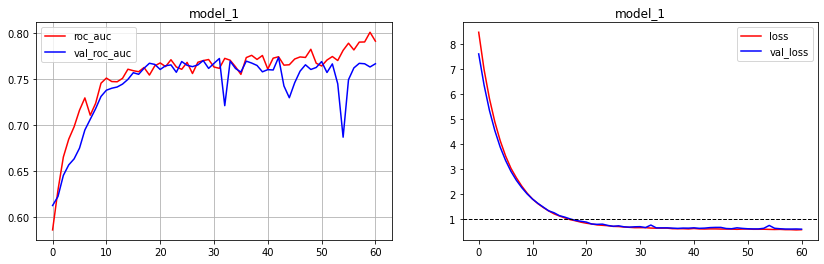

train loss: 0.6462951302528381, train roc_auc: 0.7604187726974487
val loss: 0.6392020583152771, val roc_auc: 0.7733211517333984


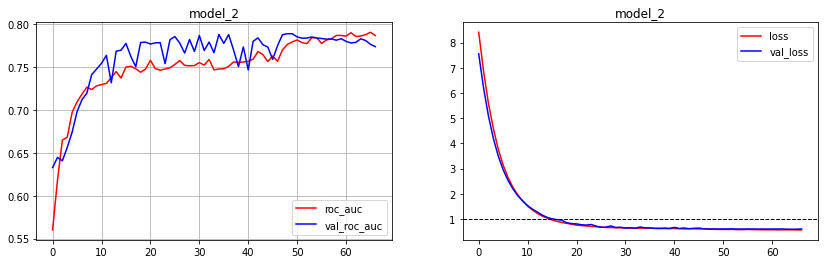

train loss: 0.5964674949645996, train roc_auc: 0.7843710780143738
val loss: 0.5972868800163269, val roc_auc: 0.788943886756897


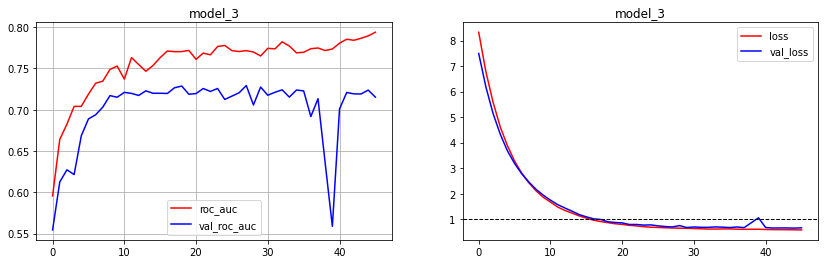

train loss: 0.6585080623626709, train roc_auc: 0.779436469078064
val loss: 0.6967263221740723, val roc_auc: 0.7293051481246948


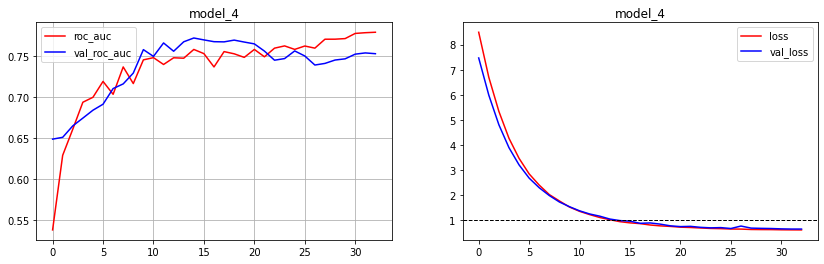

train loss: 0.9953655004501343, train roc_auc: 0.7524504065513611
val loss: 0.9921737909317017, val roc_auc: 0.7715334892272949


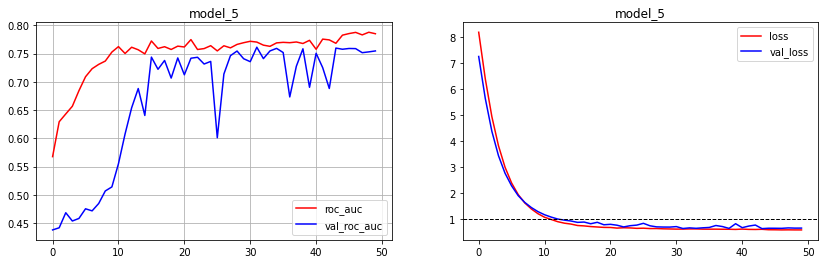

train loss: 0.6062323451042175, train roc_auc: 0.7860697507858276
val loss: 0.6230729818344116, val roc_auc: 0.7613584995269775


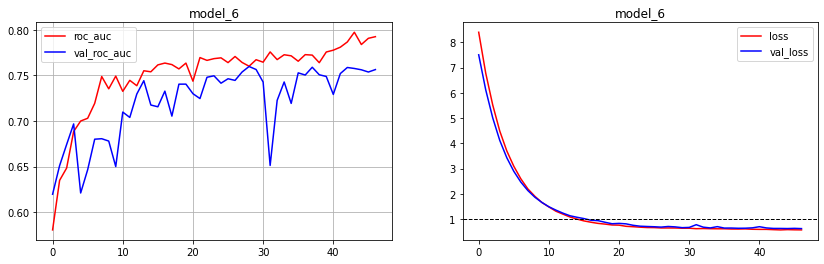

train loss: 0.6858001947402954, train roc_auc: 0.7823764085769653
val loss: 0.6921243667602539, val roc_auc: 0.759853184223175


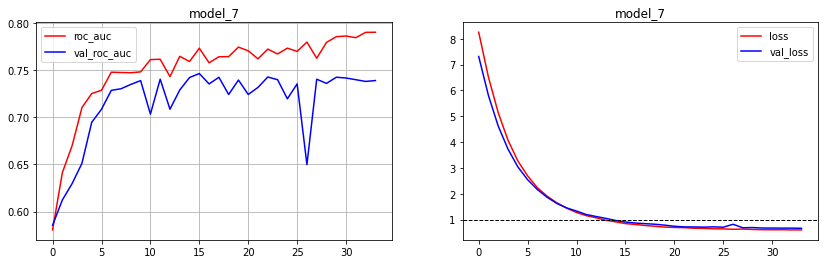

train loss: 0.8981865048408508, train roc_auc: 0.7790544629096985
val loss: 0.9060277342796326, val roc_auc: 0.7463310360908508


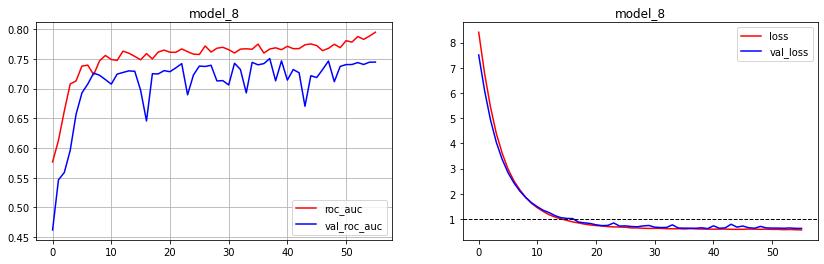

train loss: 0.6151670217514038, train roc_auc: 0.7902271747589111
val loss: 0.6364110112190247, val roc_auc: 0.7505284547805786


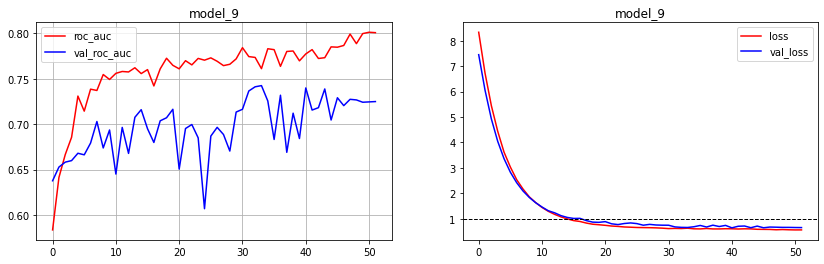

train loss: 0.6161256432533264, train roc_auc: 0.8037322759628296
val loss: 0.655627429485321, val roc_auc: 0.7425142526626587


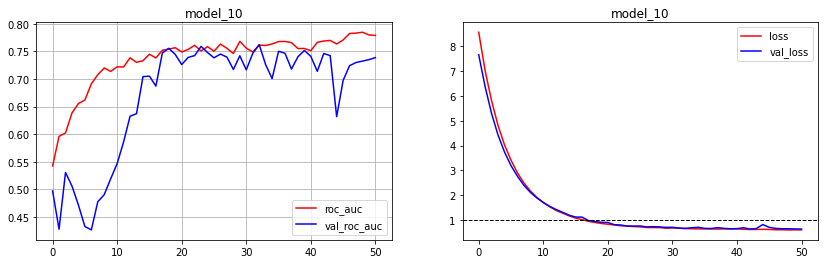

train loss: 0.6509907245635986, train roc_auc: 0.7788211703300476
val loss: 0.6579662561416626, val roc_auc: 0.7620272636413574


In [0]:
import matplotlib.pyplot as plt

n_iter = 10
preds = []
scores = []
for i in range(n_iter):
  #data split
  seq_train, seq_val, y_train_, y_val_ = \
  train_test_split(sequence_train, y_train, test_size=0.3, stratify=y_train)
  if i == 0:
    print('sequence: ',seq_train.shape, seq_val.shape, 
          '\ny: ', y_train_.shape, y_val_.shape)
  

  #model fitting
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor= 'val_roc_auc', patience=18, mode='max'),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_roc_auc', factor=0.1, patience=12, mode='max', min_lr=0.0001),
               tf.keras.callbacks.ModelCheckpoint(f'model_{i+1}.h5', monitor='val_roc_auc', verbose=0, save_best_only=True, mode='max')
               ]

  model = my_model()
  history =model.fit(seq_train, y_train_, validation_data=(seq_val, y_val_), 
             epochs=1000, batch_size=64, callbacks=callbacks, verbose = 0)
  
  # training visualization
  plt.figure(figsize=(14,4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['roc_auc'], 'r-', label='roc_auc')
  plt.plot(history.history['val_roc_auc'], 'b-', label='val_roc_auc')
  plt.legend()
  plt.title(f'model_{i+1}')
  plt.grid()
  
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], 'r-', label='loss')
  plt.plot(history.history['val_loss'], 'b-', label='val_loss')
  plt.legend()

  plt.axhline(y=1, color='black', linestyle='--', linewidth=1)
  plt.title(f'model_{i+1}')
  # plt.grid()

  plt.show()

  # predict
  model = tf.keras.models.load_model(f'model_{i+1}.h5', custom_objects={'relu6': tf.nn.relu6, 'swish' : tf.keras.activations.swish})
  score_train = model.evaluate(seq_train, y_train_,verbose=0)
  score_val = model.evaluate(seq_val, y_val_,verbose=0)
  scores.append(score_val[1])
    
  print(f'train loss: {score_train[0]}, train roc_auc: {score_train[1]}')
  print(f'val loss: {score_val[0]}, val roc_auc: {score_val[1]}')
  # print(roc_auc_score(y_val_, model.predict(seq_val)))

  pred = model.predict(sequence_test)
  preds.append(pred)

In [0]:
THRESHOLD = 0.76
print('number of selected model: ',sum(np.array(scores) > THRESHOLD))

selected_preds = np.array(preds)[np.array(scores) > THRESHOLD]

# 산술평균
# submission = pd.DataFrame({
#     'cust_id' : range(3500, 3500+2482),
#     'gender' : np.mean(selected_preds, axis=0).flat
# })

# 멱평균
p = 3.5
power_mean = (np.sum(np.array(selected_preds)**p, axis=0) / sum(np.array(scores) > THRESHOLD))**(1/p)

submission = pd.DataFrame({
    'cust_id' : range(3500, 3500+2482),
    'gender' : power_mean.flat
})

submission.to_csv('submission1.csv', index=False)

number of selected model:  5


In [0]:
pd.read_csv('submission1.csv')

,cust_id,gender
0,3500,0.611167
1,3501,0.319969
2,3502,0.423284
3,3503,0.354171
4,3504,0.473791
...,...,...
2477,5977,0.424815
2478,5978,0.402117
2479,5979,0.522821
2480,5980,0.410776
